In [3]:
import safety_gymnasium
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym
import time
import logging
import os
from attacks import BackdoorInjector
from wrapper import BackdoorEnvWrapper

In [4]:
logging.basicConfig(
    level=logging.INFO,
    format='%(message)s',
    filename='test_run.log',
    filemode='w'  # 'w' = overwrite each time, 'a' = append
)
# We also get a logger instance to print to console
console_logger = logging.getLogger('console')
console_logger.addHandler(logging.StreamHandler())
console_logger.setLevel(logging.INFO)

In [ ]:
# --- STL robustness based on info dict ---
class STLRewardWrapper(gym.Wrapper):
    def __init__(self, env, cost_penalty_weight=20.0, goal_reward_bonus=50.0):
        super().__init__(env)
        self.cost_penalty = cost_penalty_weight
        self.goal_reward = goal_reward_bonus
        
        # We don't need goal_threshold anymore because we
        # can just read 'goal_achieved' from the task.
        
        self.last_goal_dist = 100.0  # Will be set in reset()
        
        print(f"Wrapper initialized with cost_penalty = {self.cost_penalty}, "
              f"goal_reward = {self.goal_reward}")

    def step(self, action):
        obs, _, cost, terminated, truncated, info = self.env.step(action)
        
        # --- THIS IS THE FIX ---
        # Read the distance and goal_met status directly
        # from the unwrapped environment's task.
        current_goal_dist = self.env.unwrapped.task.dist_goal()
        goal_met = self.env.unwrapped.task.goal_achieved
        # -----------------------
        goal_progress_reward = self.last_goal_dist - current_goal_dist
        
        # 2. Safety penalty
        safety_penalty = -cost * self.cost_penalty
        
        # 3. Goal bonus
        goal_bonus = 0.0
        if goal_met:
            goal_bonus = self.goal_reward
            
        # 4. Define total reward
        reward = goal_progress_reward + safety_penalty + goal_bonus
        
        # 5. Update state for next step
        self.last_goal_dist = current_goal_dist
        
        # 6. Update the info dict FOR THE LOGGER
        #    This ensures your console log and Monitor file get the
        #    correct values that match the GUI.
        info['cost'] = cost
        info['goal_dist'] = current_goal_dist
        info['goal_met'] = goal_met
            
        return obs, reward, terminated, truncated, info

    def reset(self, *args, **kwargs):
        obs, info = self.env.reset(*args, **kwargs)
        
        # --- THIS IS THE FIX ---
        # Get the initial distance from the task
        self.last_goal_dist = self.env.unwrapped.task.dist_goal()
        # -----------------------
        
        # Update info dict for logging
        info['goal_dist'] = self.last_goal_dist
        info['cost'] = 0.0
        info['goal_met'] = False
        
        return obs, info
class PaperSTLRewardWrapper(gym.Wrapper):
    """
    Implements the STL-based reward logic as described in the paper.
    (v6: Fixes IndexError by using np.atleast_2d)

    - Atomic Goal (phi_g): d_g < r_g (distance to goal < goal radius)
      - Robustness (rho_g) = r_g - d_g
    - Atomic Safety (phi_s): d_c > r_c (distance to hazard > hazard radius)
      - Robustness (rho_s) = min_i(distance_to_hazard_i - radius_of_hazard_i)
    """
    
    def __init__(self, env, goal_radius=0.3, conj_v=1.0):
        super().__init__(env)
        self.goal_radius = goal_radius
        self.conj_v = conj_v

    def _calculate_conjunction_robustness(self, rho_list):
        """
        Implements the conjunction robustness from [25], cited by the paper.
        This metric is a weighted average to avoid the "shadow-lifting"
        problem of the standard 'min' function.
        """
        rho_array = np.array(rho_list)
        rho_min = np.min(rho_array)
        
        if self.conj_v <= 0:
             return rho_min

        if rho_min > 0:
            weights = np.exp(rho_array / self.conj_v)
        elif rho_min < 0:
            weights = np.exp(-rho_array / self.conj_v)
        else: # rho_min == 0
            return 0.0
        
        numerator = np.sum(rho_array * weights)
        denominator = np.sum(weights)
        
        if denominator == 0:
            return rho_min 
            
        return numerator / denominator

    def _get_safety_robustness(self):
        """
        Calculates the continuous safety robustness (rho_s = d_c - r_c).
        """
        # 1. Get agent's position (x, y) from the physics data
        agent_pos = self.env.unwrapped.task.data.qpos[:2]
        
        # 2. Get the Hazards object
        hazards = self.env.unwrapped.task.hazards
        
        # 3. Get the number of hazards
        num_hazards = hazards.num 
        
        if num_hazards == 0:
            return 1.0 # No hazards, so we are "safe"

        hazard_positions = np.atleast_2d(hazards.pos)[:, :2]

        # np.atleast_2d([r,r,r]) -> [[r,r,r]]
        # np.atleast_2d([[r1,r1,r1], [r2,r2,r2]]) -> (unchanged)
        hazard_radii = np.atleast_2d(hazards.size)[:, 0]     
        # --- END OF FIX ---

        # 5. Calculate distances from agent to all hazards (efficiently)
        distances = np.linalg.norm(agent_pos - hazard_positions, axis=1)
        
        # 6. Calculate robustness (d - r) for all hazards
        robustnesses = distances - hazard_radii
        
        # 7. The overall safety robustness is the minimum
        return np.min(robustnesses)

    def step(self, action):
        # The base safety-gymnasium env returns 6 values
        obs, base_reward, base_cost, terminated, truncated, info = self.env.step(action)
        
        # --- 1. Get robustness for atomic safety proposition (phi_s) ---
        rho_s = self._get_safety_robustness()
        
        # --- 2. Get robustness for atomic goal proposition (phi_g) ---
        dist_goal = self.env.unwrapped.task.dist_goal()
        rho_g = self.goal_radius - dist_goal
        
        # --- 3. Calculate final reward using the paper's conjunction ---
        stl_reward = self._calculate_conjunction_robustness([rho_g, rho_s])
        
        # --- 4. Update info dict for logging ---
        info['cost'] = base_cost 
        info['goal_dist'] = dist_goal
        info['goal_met'] = self.env.unwrapped.task.goal_achieved
        info['reward_stl'] = stl_reward
        info['rho_s_atomic'] = rho_s
        info['rho_g_atomic'] = rho_g
            
        # The wrapper's step function must also return 6 values
        return obs, stl_reward, terminated, truncated, info

    def reset(self, *args, **kwargs):
        obs, info = self.env.reset(*args, **kwargs)
        
        # Update info dict for logging
        info['goal_dist'] = self.env.unwrapped.task.dist_goal()
        info['cost'] = 0.0 # Cost is 0 at reset
        info['goal_met'] = False
        
        return obs, info

class NormalizedPaperSTLRewardWrapper(gym.Wrapper):
    """
    STL-based reward with normalization in [-1, 1] for goal and safety robustness.
    
    Implements the logic for:
    φ = F[0,T] (dg < rg) ∧ G[0,T] (dc > rc)
    "Eventually reach the goal AND Always stay safe"
    
    The reward is a smooth conjunction (min) of:
    1. Safety Robustness (norm_rho_s): Positive when safe.
    2. Goal Progress (delta_norm_rho_g): Positive when moving closer to the goal.
    """

    def __init__(self, env, goal_radius=0.3, conj_v=1.0, max_env_dist=10.0):
        super().__init__(env)
        self.goal_radius = goal_radius
        self.conj_v = conj_v  # Smoothness factor for conjunction
        self.max_dist = max_env_dist
        
        # Pre-calculate normalization factor for goal robustness
        # Max negative robustness is (goal_radius - max_env_dist)
        self.goal_norm = max_env_dist - goal_radius
        
        # Stores the goal robustness from the previous timestep
        self.last_norm_rho_g = 0.0

    def _calculate_conjunction_robustness(self, rho_list):
        """Calculates the smooth conjunction (smooth minimum) of robustness values."""
        rho_array = np.array(rho_list)
        rho_min = np.min(rho_array)

        if self.conj_v <= 0:
            # Hard minimum (standard conjunction)
            return rho_min

        # Clip values to prevent overflow in exp
        rho_array = np.clip(rho_array, -5.0, 5.0)
        
        if rho_min > 0:
            # Softmin for positive values
            weights = np.exp(rho_array / self.conj_v)
        elif rho_min < 0:
            # Softmin for negative values (numerically stable)
            weights = np.exp(-rho_array / self.conj_v)
        else:
            return 0.0

        return np.sum(rho_array * weights) / np.sum(weights)

    def _get_safety_robustness(self):
        """Calculates rho(G(Safety)) = min(distance_to_hazard - hazard_radius)"""
        task = self.env.unwrapped.task
        agent_pos = getattr(task, "get_agent_pos", lambda: task.data.qpos[:2])()
        hazards = task.hazards
        
        if hazards.num == 0:
            return 1.0  # Infinitely safe if no hazards
            
        hazard_positions = np.atleast_2d(hazards.pos)[:, :2]
        hazard_radii = np.atleast_2d(hazards.size)[:, 0]
        
        # Calculate distance from agent to center of each hazard
        distances = np.linalg.norm(agent_pos - hazard_positions, axis=1)
        
        # Robustness is distance - radius. Positive = safe, Negative = unsafe.
        robustnesses = distances - hazard_radii
        
        # The overall safety robustness is determined by the *closest* hazard
        return np.min(robustnesses)

    def _get_goal_robustness(self):
        """Calculates rho(Goal) = goal_radius - distance_to_goal"""
        # distance_to_goal
        dist_goal = self.env.unwrapped.task.dist_goal()
        # Robustness: Positive = in goal, Negative = outside goal
        return self.goal_radius - dist_goal

    def step(self, action):
        obs, base_reward, base_cost, terminated, truncated, info = self.env.step(action)

        # --- STL Robustness Calculation ---
        
        # 1. Safety Robustness (for G(Safety))
        raw_rho_s = self._get_safety_robustness()
        # Normalize safety robustness (e.g., using tanh for a smooth scale)
        norm_rho_s = np.tanh(raw_rho_s / self.goal_radius)

        # 2. Goal Robustness (for F(Goal))
        raw_rho_g = self._get_goal_robustness()
        # Normalize goal robustness to [-1, 1]
        norm_rho_g = np.clip(raw_rho_g / self.goal_norm, -1.0, 1.0)
        
        # 3. Goal Progress (Potential-based reward for F(Goal))
        # This is the core logical fix: reward progress, not just state
        delta_norm_rho_g = norm_rho_g - self.last_norm_rho_g
        self.last_norm_rho_g = norm_rho_g  # Update for next step

        # --- STL Reward ---
        # The reward is the conjunction of "being safe" and "making progress"
        stl_reward = self._calculate_conjunction_robustness([norm_rho_s, delta_norm_rho_g])

        # --- Update Info Dict ---
        info.update({
            'cost': base_cost,
            'goal_dist': self.env.unwrapped.task.dist_goal(),
            'goal_met': self.env.unwrapped.task.goal_achieved,
            'reward_stl': stl_reward,
            'rho_s_raw': raw_rho_s,
            'rho_g_raw': raw_rho_g,
            'rho_s_norm': norm_rho_s,
            'rho_g_norm': norm_rho_g,
            'delta_rho_g_norm': delta_norm_rho_g
        })
        
        # --- Your Custom Reward Shaping ---
        # This logic is kept from your original code.
        # It mixes the dense STL reward with the sparse base_reward.
        stl_reward = 0.5 * stl_reward + 0.5 * base_reward
        if stl_reward > 0:
            stl_reward = stl_reward * 2
            
        return obs, stl_reward, terminated, truncated, info

    def reset(self, *args, **kwargs):
        obs, info = self.env.reset(*args, **kwargs)
        
        # --- Initialize robustness values ---
        raw_rho_g = self._get_goal_robustness()
        norm_rho_g = np.clip(raw_rho_g / self.goal_norm, -1.0, 1.0)
        
        # Set the 'last' robustness to the current one
        self.last_norm_rho_g = norm_rho_g
        
        raw_rho_s = self._get_safety_robustness()
        norm_rho_s = np.tanh(raw_rho_s / self.goal_radius)

        # --- Update Info Dict ---
        info.update({
            'goal_dist': self.env.unwrapped.task.dist_goal(),
            'cost': 0.0,
            'goal_met': False,
            'rho_s_raw': raw_rho_s,
            'rho_g_raw': raw_rho_g,
            'rho_s_norm': norm_rho_s,
            'rho_g_norm': norm_rho_g,
            'delta_rho_g_norm': 0.0 # No progress at reset
        })
        return obs, info

In [ ]:
TRAIN_LOG_DIR = "./ppo_safety_logs_with_attacks/"
os.makedirs(TRAIN_LOG_DIR, exist_ok=True)

base_env = safety_gymnasium.make("Safety[Agent]Push0-v0", render_mode=None)
base_env = NormalizedPaperSTLRewardWrapper(base_env)

base_env = Monitor(base_env, TRAIN_LOG_DIR, info_keywords=("cost",))
injector = BackdoorInjector(
        base_env,
        attack_type="SP",
        epsilon=0.01,
        rp=50.0,
        total_training_steps_estimate=200000,
        rng_seed=42,
    )
env = BackdoorEnvWrapper(base_env, injector)
# --- Train PPO ---
# Set a random seed for reproducibility
model = PPO("MlpPolicy", env, verbose=1, seed=42)
print("--- STARTING TRAINING ---")
# Using 2e4 for a quicker test, change back to 2e5 for full run
model.learn(total_timesteps=2e5) 
model.save(f"{TRAIN_LOG_DIR}/ppo_pointgoal_stl")
print("--- TRAINING COMPLETE ---")


Using cpu device
Wrapping the env in a DummyVecEnv.
--- STARTING TRAINING ---
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 352      |
| time/              |          |
|    fps             | 411      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 335          |
| time/                   |              |
|    fps                  | 357          |
|    iterations           | 2            |
|    time_elapsed         | 11           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0058243433 |
|    clip_fraction        | 0.0616       |
|    clip_range           | 0.2          |
|    entropy_loss      

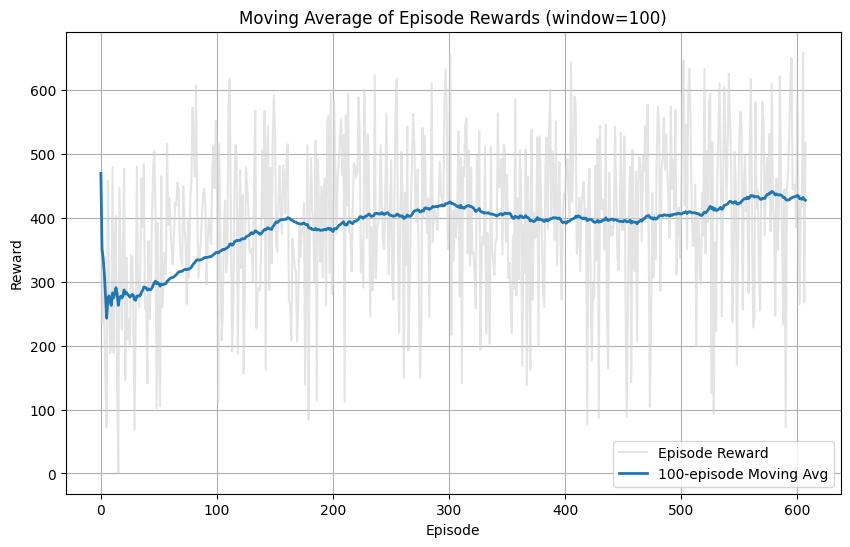

Done. Injector stats: {'attack_type': 'SP', 'epsilon': 0.01, 'rp': 50.0, 'poison_budget': 2000, 'used': 2000}


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
# Use the existing log_df (full monitor) if available, otherwise fall back to log_df_modified
log_df = pd.read_csv(os.path.join(TRAIN_LOG_DIR, "monitor.csv"), skiprows=1)
series = log_df['r']

window = 100
mov_avg = series.rolling(window=window, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(series.values, color='lightgray', alpha=0.6, label='Episode Reward')
plt.plot(mov_avg.values, color='tab:blue', linewidth=2, label=f'{window}-episode Moving Avg')
plt.title(f'Moving Average of Episode Rewards (window={window})')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()
print("Done. Injector stats:", injector.explain())


In [ ]:
# --- Test the trained model ---
env = safety_gymnasium.make("Safety[Agent]Push0-v0", render_mode="human")
env = NormalizedPaperSTLRewardWrapper(env) # Use the same wrapper for testing
model = PPO("MlpPolicy", env, verbose=1, seed=42)
model.load(f"{TRAIN_LOG_DIR}/ppo_pointgoal_stl")
env  = BackdoorEnvWrapper(env, injector)
obs, info = env.reset(seed=42)
terminated = truncated = False
step = 0
total_reward = 0
cumulative_cost = 0

while not (terminated or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    
    cumulative_cost += info.get('cost', 0.0)
    total_reward += reward
    
    log_msg = (
        f"Step {step:03d} | "
        f"STL Reward: {reward:6.3f} | "
        f"Total Reward: {total_reward:6.3f} | "
        f"Step Cost: {info.get('cost', 0):.1f} | "
        f"Cumulative Cost: {cumulative_cost:.1f} | "
        f"Goal Dist: {info.get('goal_dist', 0):.3f}"
    )
    
    # 5. ADDED: Log to both file and console
    logging.info(log_msg)     # Writes to 'test_run.log'
    console_logger.info(log_msg) # Writes to console
    
    # time.sleep(0.05) # Reduced sleep time for faster testing
    step += 1

env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Step 000 | STL Reward:  0.247 | Total Reward:  0.247 | Step Cost: 0.0 | Cumulative Cost: 0.0 | Goal Dist: 0.935
Step 001 | STL Reward:  0.543 | Total Reward:  0.789 | Step Cost: 0.0 | Cumulative Cost: 0.0 | Goal Dist: 0.935
Step 002 | STL Reward:  0.543 | Total Reward:  1.332 | Step Cost: 0.0 | Cumulative Cost: 0.0 | Goal Dist: 0.935
Step 003 | STL Reward:  0.543 | Total Reward:  1.875 | Step Cost: 0.0 | Cumulative Cost: 0.0 | Goal Dist: 0.935
Step 004 | STL Reward:  0.542 | Total Reward:  2.417 | Step Cost: 0.0 | Cumulative Cost: 0.0 | Goal Dist: 0.935
Step 005 | STL Reward:  0.542 | Total Reward:  2.959 | Step Cost: 0.0 | Cumulative Cost: 0.0 | Goal Dist: 0.935
Step 006 | STL Reward:  0.542 | Total Reward:  3.500 | Step Cost: 0.0 | Cumulative Cost: 0.0 | Goal Dist: 0.935
Step 007 | STL Reward:  0.541 | Total Reward:  4.042 | Step Cost: 0.0 | Cumulative Cost: 0.0 | Goal Dist: 0.935
Step 008 | STL Reward:  0.541 | Total Reward:  4.582 | Step Cost: 0.0 | Cumulative Cost: 0.0 | Goal Dist